<a href="https://colab.research.google.com/github/MariaPetrovskaya/Data-Science-demo/blob/main/Time_series_method_predictions_for_taxi_service.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn import metrics


from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

<b> Результат: </b>загрузка всех библиотек

In [ ]:
df = pd.read_csv('/datasets/taxi.csv')
#data  = df.copy()
#
print('загрузка и знакомство с данными')
print (df.shape)
print (df.info())
print (df.head())

загрузка и знакомство с данными
(26496, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None
              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


<b> Результат: </b>Загружены данные и просмотрена основная информация по датасету.

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print('загрузка и знакомство с данными')
print (data.shape)
print (data.info())
print (data.head())
print (data.tail())

загрузка и знакомство с данными
(26496, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
                     num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53


**Результат** Данные загружены с сортировкой, столбец datetime  стал индексом

In [ ]:
data.sort_index(inplace=True) # < напишите код здесь >
print(data.index.is_monotonic)
print(data.info())# < напишите код здесь >

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


**Результат** Проверка что индекс монотонный

<AxesSubplot:xlabel='datetime'>

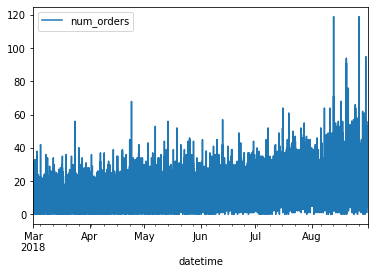

In [ ]:
data.plot()

(4416, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


<AxesSubplot:xlabel='datetime'>

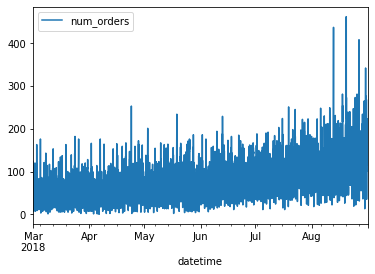

In [ ]:
data = data.resample('1H').sum()
print (data.shape)
print (data.info())
print (data.head())# < напишите код здесь >
data.plot()

**Результат** Проведено ресемплирование по одному часу.Количество строк в датасете сократилось с 26496 до 4416

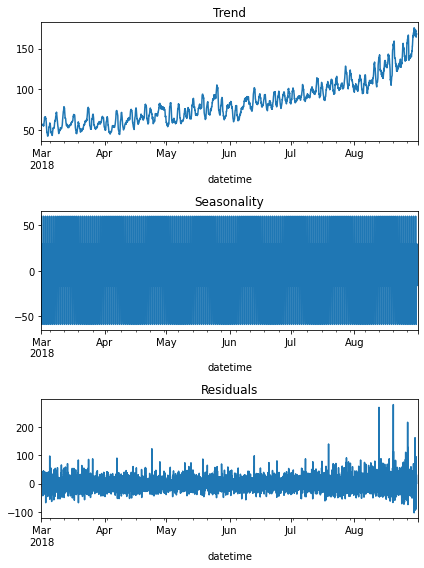

In [ ]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-08-31'].plot(ax=plt.gca())# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()


**Результат** получился график тренда и 'Residuals', сезонные колебания - в рамках года не показательно

## Анализ

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()# < напишите код здесь >

make_features(data, 4, 4)
print(data.head())
print(data.tail())

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   

                     lag_3  lag_4  rolling_mean  
datetime                                         
2018-03-01 00:00:00    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN           NaN  
2018-03-01 04:00:00   85.0  124.0          86.5  
                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                 

**Результат** Создана функция,формирующая столбцы-признаки

In [ ]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.25)

 

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print('features_train shape:', features_train.shape)
print('features_valid shape:', features_valid.shape)
print('features_test shape:', features_test.shape)
print()
print('target_train shape:', target_train.shape)
print('target_valid shape:', target_valid.shape)
print('target_test shape:', target_test.shape)

features_train shape: (2980, 9)
features_valid shape: (994, 9)
features_test shape: (442, 9)

target_train shape: (2980,)
target_valid shape: (994,)
target_test shape: (442,)


**Результат** Датасет разделен на обучающую, валидизационную и тестовую выборки без смешивания

In [ ]:
train = train.dropna()
valid = valid.dropna()
test = test.dropna()


features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print('features_train shape:', features_train.shape)
print('features_valid shape:', features_valid.shape)
print('features_test shape:', features_test.shape)
print()
print('target_train shape:', target_train.shape)
print('target_valid shape:', target_valid.shape)
print('target_test shape:', target_test.shape)

features_train shape: (2976, 9)
features_valid shape: (994, 9)
features_test shape: (442, 9)

target_train shape: (2976,)
target_valid shape: (994,)
target_test shape: (442,)


**Результат** Удалены пропуски

In [ ]:
for column in features_train:
    print(column)

month
day
dayofweek
hour
lag_1
lag_2
lag_3
lag_4
rolling_mean


## Обучение

**подбор модели на тренировочной выборке**

In [ ]:
def rmse (target, predict):
    rmse = mean_squared_error(target, predict)**0.5
    return rmse

In [ ]:
%%time
model = LinearRegression()# < напишите код здесь >

model.fit(features_train,target_train) # < обучите модель >
print('модель обучена')

модель обучена
CPU times: user 4.89 ms, sys: 149 µs, total: 5.04 ms
Wall time: 3.93 ms


In [ ]:
%%time
predictions_train= model.predict(features_valid)
result_train = mean_squared_error(target_valid,predictions_train)**0.5
print ('модель линейной регрессии с проверкой на валидизационной выборке')
print("RMSE обучающей выборки:", result_train)

модель линейной регрессии с проверкой на валидизационной выборке
RMSE обучающей выборки: 37.46172124377716
CPU times: user 9.41 ms, sys: 243 µs, total: 9.66 ms
Wall time: 4.56 ms


In [ ]:
%%time
best_mod = None
best_res = 3000
best_dep = 0
for depth in range(1, 60, 1):
    for est in range(15, 351, 15):
        model = RandomForestRegressor(n_estimators=est, 
        max_depth=depth, random_state=12345) 
        print(model)
        model.fit(features_train, target_train)
        model.predict(features_valid)
        preditions_forest = model.predict(features_valid) 
        res_forest = mean_squared_error(target_valid, preditions_forest)**0.5
        print("RMSE модели случайного леса на обучающей выборке:", res_forest)
        if res_forest < best_res:
            best_mod = model
            best_res = res_forest
            best_deр = depth
print('Cамая эффективная модель - best_mod',best_mod)
print("RMSE наилучшей модели:", best_res)

RandomForestRegressor(max_depth=1, n_estimators=15, random_state=12345)
RMSE модели случайного леса на обучающей выборке: 46.91784317489029
RandomForestRegressor(max_depth=1, n_estimators=30, random_state=12345)
RMSE модели случайного леса на обучающей выборке: 46.94453570610136
RandomForestRegressor(max_depth=1, n_estimators=45, random_state=12345)
RMSE модели случайного леса на обучающей выборке: 46.979655510969316
RandomForestRegressor(max_depth=1, n_estimators=60, random_state=12345)
RMSE модели случайного леса на обучающей выборке: 46.86063409528168
RandomForestRegressor(max_depth=1, n_estimators=75, random_state=12345)
RMSE модели случайного леса на обучающей выборке: 46.83191195364373
RandomForestRegressor(max_depth=1, n_estimators=90, random_state=12345)
RMSE модели случайного леса на обучающей выборке: 46.861982482909184
RandomForestRegressor(max_depth=1, n_estimators=105, random_state=12345)
RMSE модели случайного леса на обучающей выборке: 46.915751181986856
RandomForestRegr

In [ ]:
%%time

best_model = None
best_result = 3000
best_depth = 0
for depth in range(1, 100):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    print(model)
    model.fit(features_train, target_train)
    model.predict(features_valid)
    predictions_tree= model.predict(features_valid)
    result_tree = mean_squared_error(target_valid, predictions_tree)**0.5
    print("RMSE модели дерева решений на обучающей выборке:", result_tree)
    if result_tree < best_result:
            best_model = model
            best_result = result_tree
            best_deрth = depth
print('Cамая эффективная модель - best_mod',best_model)
print("RMSE наилучшей модели:", best_result)

DecisionTreeRegressor(max_depth=1, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 46.224312697856604
DecisionTreeRegressor(max_depth=2, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 44.54195713032969
DecisionTreeRegressor(max_depth=3, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 41.23764379900678
DecisionTreeRegressor(max_depth=4, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 40.21977340261399
DecisionTreeRegressor(max_depth=5, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 38.643180493030655
DecisionTreeRegressor(max_depth=6, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 37.11042676396742
DecisionTreeRegressor(max_depth=7, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 35.5114581546083
DecisionTreeRegressor(max_depth=8, random_state=12345)
RMSE модели дерева решений на обучающей выборке: 34.410987466169345
DecisionTreeRegressor(

**Примечание** Предыдущие модели работают только с количественными данными. По сути данные месяц, дата, день недели, час - категориальные, хотя зашифрованы цифрой. 

Принято решение попробовать модель CatBoostRegressor, работающую с категориалными переменными.

In [ ]:
%%time

cat_features = ['month', 'day',
                'dayofweek', 'hour']

model = CatBoostRegressor(loss_function="RMSE", iterations=150) 

model.fit(features_train, target_train, cat_features=cat_features)
print('время обучения модели')

Learning rate set to 0.227432
0:	learn: 32.0123739	total: 50.3ms	remaining: 7.49s
1:	learn: 29.2486407	total: 53.7ms	remaining: 3.97s
2:	learn: 27.2713614	total: 56.5ms	remaining: 2.77s
3:	learn: 25.6003666	total: 59.3ms	remaining: 2.17s
4:	learn: 24.4329123	total: 62ms	remaining: 1.8s
5:	learn: 23.6470084	total: 64.7ms	remaining: 1.55s
6:	learn: 23.0383563	total: 67.2ms	remaining: 1.37s
7:	learn: 22.5865977	total: 69.7ms	remaining: 1.24s
8:	learn: 22.2836736	total: 72.4ms	remaining: 1.13s
9:	learn: 22.0586355	total: 74.7ms	remaining: 1.04s
10:	learn: 21.8557482	total: 77.1ms	remaining: 975ms
11:	learn: 21.6707487	total: 79.6ms	remaining: 916ms
12:	learn: 21.5347793	total: 82.2ms	remaining: 866ms
13:	learn: 21.3633216	total: 84.6ms	remaining: 821ms
14:	learn: 21.3000828	total: 87ms	remaining: 783ms
15:	learn: 21.2636381	total: 88.1ms	remaining: 738ms
16:	learn: 21.1982265	total: 90.4ms	remaining: 707ms
17:	learn: 21.1118283	total: 92.8ms	remaining: 681ms
18:	learn: 21.0489748	total: 95

In [ ]:
%%time
pred_valid = model.predict(features_valid) 
print('время предсказания')
result_cat = mean_squared_error(target_valid, pred_valid)**0.5
print("RMSE cat на валидационной выборке:", result_cat)

время предсказания
RMSE cat на валидационной выборке: 34.73717672822379
CPU times: user 5.06 ms, sys: 0 ns, total: 5.06 ms
Wall time: 3.55 ms


In [ ]:
print('результаты сравнения разных моделей на тренировочной выборке')
print()
print('LinearRegression')
print ('модель линейной регрессии с проверкой на валидизационной выборке')
print("RMSE обучающей выборки:", result_train)
print()
print('RandomForestRegressor')
print('Cамая эффективная модель - best_mod',best_mod)
print("RMSE наилучшей модели:", best_res)
print()
print('DecisionTreeRegressor')
print('RMSE наилучшей модели:', best_result)
print('Cамая эффективная модель - best_mod',best_model)
print()
print('модель CatBoostRegressor')
print("RMSE cat на валидационной выборке:", result_cat)
print()

результаты сравнения разных моделей на тренировочной выборке

LinearRegression
модель линейной регрессии с проверкой на валидизационной выборке
RMSE обучающей выборки: 37.46172124377716

RandomForestRegressor
Cамая эффективная модель - best_mod RandomForestRegressor(max_depth=16, n_estimators=75, random_state=12345)
RMSE наилучшей модели: 31.712580075388782

DecisionTreeRegressor
RMSE наилучшей модели: 33.64934127994021
Cамая эффективная модель - best_mod DecisionTreeRegressor(max_depth=10, random_state=12345)

модель CatBoostRegressor
RMSE cat на валидационной выборке: 34.73717672822379



## Тестирование

Последовательно применим модели на тестовой выборке

In [ ]:
features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']
print('features_train_valid shape:', features_train_valid.shape)
print('target_train_valid shape:', target_train_valid.shape)
train_valid = train_valid.dropna()
print('features_train_valid shape:', features_train_valid.shape)
print('target_train_valid shape:', target_train_valid.shape)


features_train_valid shape: (3970, 9)
target_train_valid shape: (3970,)
features_train_valid shape: (3970, 9)
target_train_valid shape: (3970,)


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения: для обучения модели использовалась выборка, объединяющая тестовую и тренировочную ...
</div>

In [ ]:
%%time
model = RandomForestRegressor(n_estimators=75, 
max_depth=16, random_state=12345) 
print(model)
model.fit(features_train_valid, target_train_valid)
print('время обучения модели')       

RandomForestRegressor(max_depth=16, n_estimators=75, random_state=12345)
время обучения модели
CPU times: user 1.14 s, sys: 7.98 ms, total: 1.15 s
Wall time: 1.15 s


In [ ]:
%%time
model.predict(features_test)
preditions_forest_test = model.predict(features_test) 
res_forest_test = mean_squared_error(target_test, preditions_forest_test)**0.5
print("RMSE модели случайного леса на тестовой выборке:", res_forest_test)

RMSE модели случайного леса на тестовой выборке: 47.2247566540311
CPU times: user 23.3 ms, sys: 7.9 ms, total: 31.2 ms
Wall time: 29.2 ms


In [ ]:
print(preditions_forest_test)

[ 97.97669659  99.23771838 135.94038203 125.11092929  86.88911111
  97.37819736  89.50996478 105.53744792 122.31222222 117.26266667
 188.94666667 128.87466025 141.87036492 168.278      134.93874353
  65.46222222  41.13333333  44.73096296  76.39488889 119.20454472
 128.04951963 119.18281797 104.22555983 104.28849336  86.76146032
 103.35425352 131.4949011  117.24120716  97.18930584  93.30400525
  89.5700095  113.86576445 101.49616898 120.14162963 172.06666667
 160.13       168.46666667 151.6264127  133.45333333  66.63536508
  47.26        35.54962963  86.13444444 122.08914238 121.25008312
 112.59507987  99.39815223  96.41110687  88.11255572 100.52472021
 137.60179682 131.16148226  92.35998413  92.26853927  95.73494272
 118.67235979 126.13299145 128.68761905 187.78666667 164.67851852
 162.37277778 155.95733333 138.33888889  72.02222222  54.22666667
  37.78740741  80.15       122.94777839 126.0305383  103.32202078
 102.32566197  95.35864303  79.544035    83.33382638 135.21774925
 132.63746

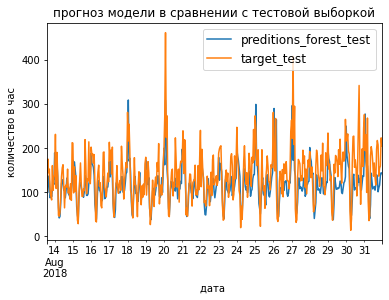

In [ ]:

test['target_test'] = target_test
test['preditions_forest_test'] = preditions_forest_test.tolist()
test['preditions_forest_test'].plot()
test['target_test'].plot()

plt.xlabel("дата ")
plt.ylabel("количество в час")
plt.legend(loc='upper right', fontsize='large')
plt.title("прогноз модели в сравнении с тестовой выборкой")
plt.show()

In [ ]:
print('проверка модели на тестовой выборке')
print()

print()
print('RandomForestRegressor')
print('Cамая эффективная модель - best_mod',best_mod)
print("RMSE модели случайного леса на тестовой выборке:", res_forest_test)
print()



проверка модели на тестовой выборке


RandomForestRegressor
Cамая эффективная модель - best_mod RandomForestRegressor(max_depth=16, n_estimators=75, random_state=12345)
RMSE модели случайного леса на тестовой выборке: 47.2247566540311

